In [1]:
# imports
import sys, os
sys.path.append(os.path.dirname(os.path.abspath('')).split("src")[0])

from os import walk

import json
import pandas as pd
import numpy as np
from typing import List

from src.cup_scripts.utils import load_train, load_test

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Latin Modern Roman'
matplotlib.rcParams['figure.dpi'] = 240

# set font for LaTeX
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Latin Modern Roman'
matplotlib.rcParams['mathtext.it'] = 'Latin Modern Roman:italic'
matplotlib.rcParams['mathtext.bf'] = 'Latin Modern Roman:bold'

In [2]:
class DataSet:
    def __init__(self,name:str,data:List,number_keys,enum_keys,list_keys,tts):
        self.name = name
        self.data = data
        self.number_keys = number_keys
        self.enum_keys = enum_keys
        self.list_keys = list_keys
        self.tts = tts

### Meta Data Exploration

In the config section, you can define the Fields you want the get explored. Please add the field based on its type to the corresponding list.
For the List Fields, the distribution of the lengths of the field will be shown. 

In [3]:
# config


data_sets :List[DataSet] = []


In [4]:
# load local data

meta_data = []
TRAIN_SPLIT = 0.75
meta_data_files = []

from data_generator.batch_data_path_generator import get_original_folder_path
from utils.SYSCONFIG import DATA_GAIT

original_data_path = get_original_folder_path(data_subset_name=DATA_GAIT)

meta_data_gait = []

for (dirpath, dirnames, filenames) in walk(original_data_path):
    for filename in filenames:
        if ".json" in filename and not "normalization" in filename: 
            path = original_data_path+"\\"+filename
            file = open(path)
            map = json.load(file)
            meta_data.append(map)
            meta_data_gait.append(map)

    break
NUMBER_FIELDS = ["Age","Height","Weight","BMI","WalkedDistance","WalkingSpeed"]
ENUM_FIELDS = ["Gender","Laterality","Sensor","PathologyGroup","IsControl"]

data_sets.append(DataSet("Local Data",meta_data,NUMBER_FIELDS,ENUM_FIELDS,[],TRAIN_SPLIT))

2022-07-10 20:26:19.691333   [UtilFunctions] Found an existing folder for C:\Informatik\workspaces\workspace_python\AI-Cup\data\gait


In [5]:
# load cup data
X_train, y_train, metadata_train = load_train()
X_test, metadata_test = load_test()

In [6]:
gait_ages = []
train_ages = []

for i in range(len(meta_data_gait)):
    try:
        gait_ages.append(meta_data_gait[i]['Age'])
    except:
        print(meta_data_gait[i])

for i in range(len(metadata_train)):
    train_ages.append(metadata_train[i]['Age'])

(array([0.01427336, 0.02292388, 0.02465398, 0.01585928, 0.01787774,
        0.01038062, 0.01081315, 0.01672434, 0.00619954, 0.00735294]),
 array([ 0. ,  6.8, 13.6, 20.4, 27.2, 34. , 40.8, 47.6, 54.4, 61.2, 68. ]),
 <BarContainer object of 10 artists>)

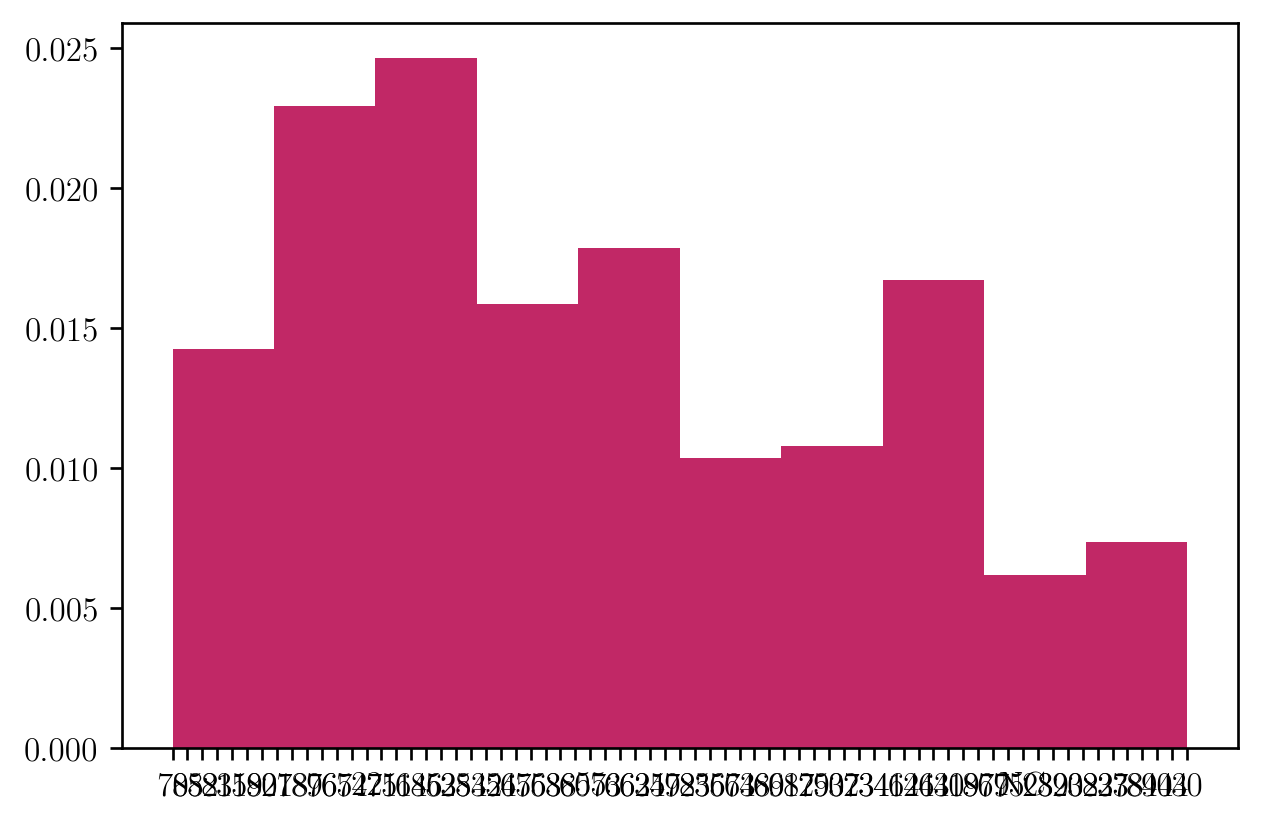

In [7]:
plt.hist(gait_ages, color="b",alpha=0.6, density=True)
plt.hist(train_ages,color="r",alpha=0.6, density=True)

In [8]:
import random

for i in range(len(X_test)):
    metadata_test[i]["RunRows"] = X_test[i].shape[0]
for i in range(len(X_train)):
    metadata_train[i]["RunRows"] = X_train[i].shape[0]

metadata_train_shuffled = metadata_train.copy()
random.shuffle(metadata_train_shuffled)

TRAIN_SPLIT = len(metadata_train) / (len(metadata_train) + len(metadata_test))
print(TRAIN_SPLIT)
print(len(metadata_train))
print(len(metadata_test))
meta_data = metadata_train_shuffled
meta_data.extend(metadata_test)

# load local data
NUMBER_FIELDS = ["Age","Height","Weight","BMI","WalkedDistance","WalkingSpeed","RunRows"]
ENUM_FIELDS = ["Gender","Laterality","Sensor","PathologyGroup","IsControl"]
data_sets.append(DataSet("Cup Data",meta_data,NUMBER_FIELDS,ENUM_FIELDS,[],TRAIN_SPLIT))

0.7472527472527473
2040
690


In [9]:
def explore_dataset(data_set:DataSet):
    
    NUMBER_FIELDS = data_set.number_keys
    ENUM_FIELDS = data_set.enum_keys
    LIST_FIELDS = data_set.list_keys

    # Includes KEY: [INT] where [INT] is a list of all values of the key over all meta data files
    values_dict = {}

    # Includes a numeric value for each string value possibility for each enum key
    # Example: {"Gender":{"M":0,"F":1}}
    enum_number_dict = {}

    print(f"Explore dataset: {data_set.name}")

    for map in data_set.data:
        for number_field in NUMBER_FIELDS:

            values = []
            if number_field in values_dict: 
                values = values_dict[number_field]

            if number_field in map: 
                value = map[number_field]
                if type(value) is not str:
                    values.append(value)
                else: 
                    # print(f"Value -{value}- of type {type(value)} is not an int!")
                    pass
            
            values_dict[number_field] = values

        for list_fields in LIST_FIELDS:

            values = []
            if list_fields in values_dict: 
                values = values_dict[list_fields]

            if list_fields in map: 
                value = map[list_fields]
                values.append(len(value))

            values_dict[list_fields] = values

        for enum_field in ENUM_FIELDS:

            values = []
            if enum_field in values_dict: 
                values = values_dict[enum_field]

            if enum_field in map: 
                str_value = map[enum_field]

                # is there already a str->int map for this enum?
                if enum_field in enum_number_dict:
                    if not str_value in enum_number_dict[enum_field]:
                        int_value = len(enum_number_dict[enum_field])
                        enum_number_dict[enum_field][str_value] = int_value
                    
                # if not, create one with this option as the first entry
                else: 
                    enum_number_dict[enum_field] = {str_value: 0}

                # now, the int_value is accessible in any case
                int_value = enum_number_dict[enum_field][str_value]
                values.append(int_value)
            
                
            values_dict[enum_field] = values
    
    print("Exploration:")
    data_set.values_dict = values_dict
    data_set.enum_number_dict = enum_number_dict

In [21]:

labels = {
    'RunRows': "Time series length",
    'Age' : 'Age',
    'Height' : 'Height',
    'Weight' : 'Weight',
    'BMI' : 'BMI',
    'WalkedDistance' : 'Walked Distance',
    'WalkingSpeed' : 'Walking Speed',
    'RightFootActivity' : 'Right Foot Activity',
    'LeftFootActivity' : 'Left Foot Activity',
    'Gender' : 'Gender',
    'Laterality' : 'Laterality',
    'Sensor' : 'Sensor',
    'PathologyGroup' : 'Pathology Group',
    'IsControl' : 'Is Control',
}

labels_lower = {
    'RunRows': "time series length",
    'Age' : 'age',
    'Height' : 'height',
    'Weight' : 'weight',
    'BMI' : 'BMI',
    'WalkedDistance' : 'walked distance',
    'WalkingSpeed' : 'walking speed',
    'RightFootActivity' : 'right foot activity',
    'LeftFootActivity' : 'left foot activity',
    'Gender' : 'gender',
    'Laterality' : 'laterality',
    'Sensor' : 'sensor',
    'PathologyGroup' : 'pathology group',
    'IsControl' : 'control group',
}

def visualize_data_set(data_set: DataSet):
    
    values_dict = data_set.values_dict
    enum_number_dict = data_set.enum_number_dict 

    print(f"--- Visualization of {data_set.name} ---")

    fig = plt.figure(constrained_layout=True)

    #fig.suptitle(f"Distribution exploration of the {data_set.name}", fontsize=24)

    n_rows = len(values_dict.keys())
    fig.set_size_inches(12,3 * n_rows)
    # create 3x1 subfigs
    subfigs = fig.subfigures(nrows=n_rows, ncols=1)
    i = 0



    for key in values_dict.keys():
        print(f"'{key}' : '{key}',")
        # load data 
        values = values_dict[key]
        
        index = round(len(values) * data_set.tts)
        last_values = values[index:]
        first_values = values[:index]
        all_values = values

        subfigs[i].suptitle(f'Exploration of the {labels_lower[key]} distribution', fontsize=16, x=0.5)
        (ax1, ax2) = subfigs[i].subplots(1, 2)
        # 
        N_BINS = 15
        min_value = min(min(values),min(last_values))
        max_value = max(max(values),max(last_values))

        bin_range = (max_value - min_value) / N_BINS
       
        bins = [min_value + x * bin_range for x in range(N_BINS + 1)]
        bins = 15
        n, bins, patches = ax1.hist(values, bins=bins, facecolor='#ffa0a0',alpha=0.5, edgecolor='#000000', linewidth=1, density=True, label="Training Data")
        n, bins, patches = ax1.hist(last_values, bins=bins, facecolor='#a0a0ff',alpha=0.5, edgecolor='#000000', linewidth=1, density=True, label='Evaluation Data')
        ax2.scatter(list(range(0,len(values))),values,  facecolor='#ffa0a0',alpha=0.7,linewidth=1,  s=4, label="Training Data")
        ax2.scatter(list(range(index, index + len(last_values))),last_values, facecolor='#a0a0ff',alpha=0.7,  linewidth=1, s=4, label='Evaluation Data')

        #if i == 0: subfigs[i]
        #if i == 0: subfigs[i].legend(loc='upper right', bbox_to_anchor = (1.0, 1.07))

        ax1.set_xlabel(labels[key])
        ax1.set_title('Distribution')
        ax1.set_ylabel('Frequency')
        ax1.legend(loc='upper right',)

        ax2.set_xlabel('Segment index')
        ax2.set_title(f'Distribution across index')
        ax2.set_ylabel(labels[key])
        ax2.legend(loc='upper right',)


        if key in ENUM_FIELDS:
            x = list(range(0,len(enum_number_dict[key])))
            y = x.copy()
            x_ticks_labels = list(enum_number_dict[key].keys())

            # Set number of ticks for x-axis
            ax1.set_xticks(x)
            # Set ticks labels for x-axis
            ax1.set_xticklabels(x_ticks_labels, rotation='horizontal')

            ax2.set_yticks(x)
            ax2.set_yticklabels(x_ticks_labels, rotation='vertical')

        i += 1

    # fig.legend()


Explore dataset: Local Data
Exploration:
--- Visualization of Local Data ---
'Age' : 'Age',
'Height' : 'Height',
'Weight' : 'Weight',
'BMI' : 'BMI',
'WalkedDistance' : 'WalkedDistance',
'WalkingSpeed' : 'WalkingSpeed',
'Gender' : 'Gender',
'Laterality' : 'Laterality',
'Sensor' : 'Sensor',
'PathologyGroup' : 'PathologyGroup',
'IsControl' : 'IsControl',
Explore dataset: Cup Data
Exploration:
--- Visualization of Cup Data ---
'Age' : 'Age',
'Height' : 'Height',
'Weight' : 'Weight',
'BMI' : 'BMI',
'WalkedDistance' : 'WalkedDistance',
'WalkingSpeed' : 'WalkingSpeed',
'RunRows' : 'RunRows',
'Gender' : 'Gender',
'Laterality' : 'Laterality',
'Sensor' : 'Sensor',
'PathologyGroup' : 'PathologyGroup',
'IsControl' : 'IsControl',


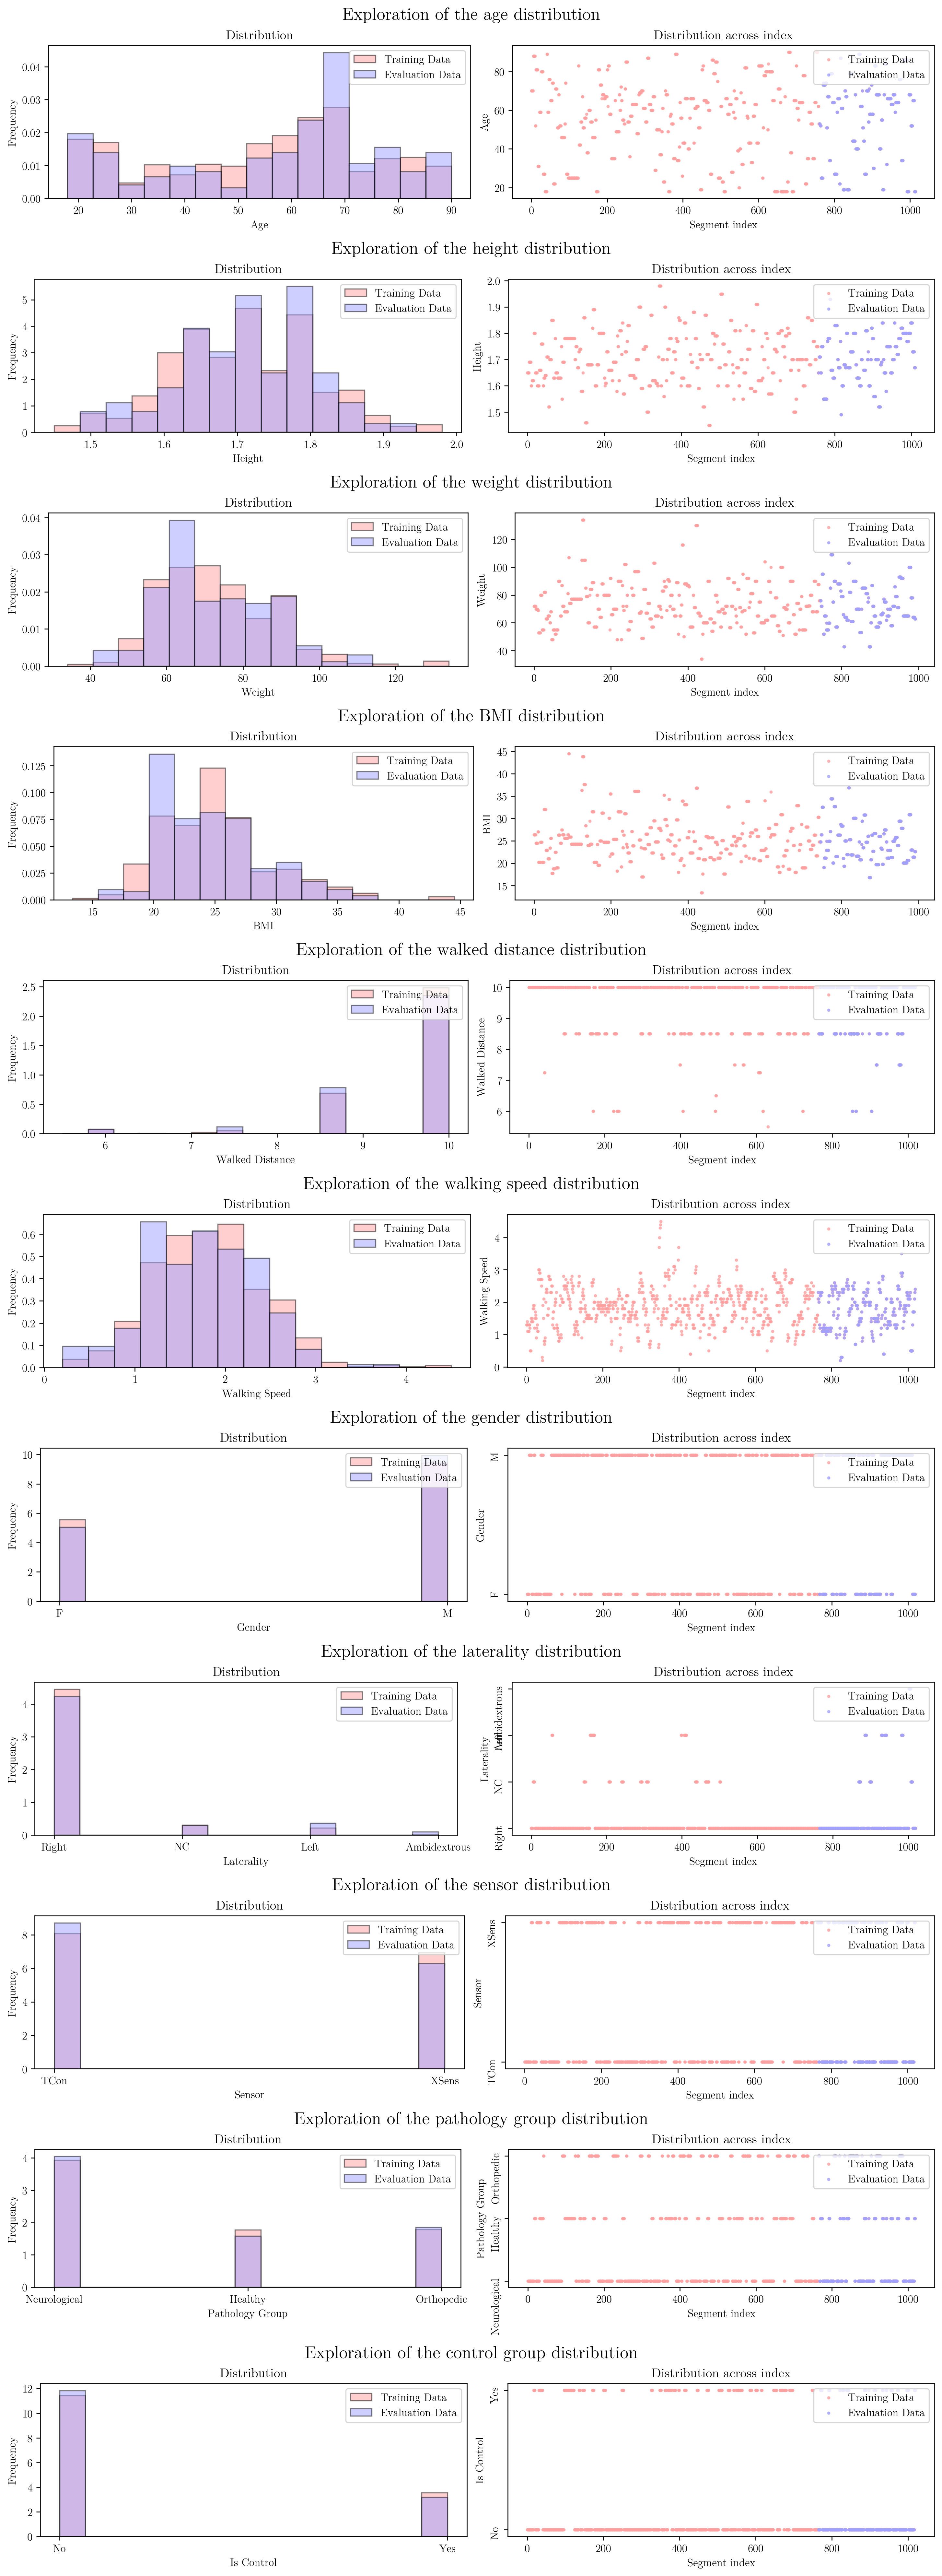

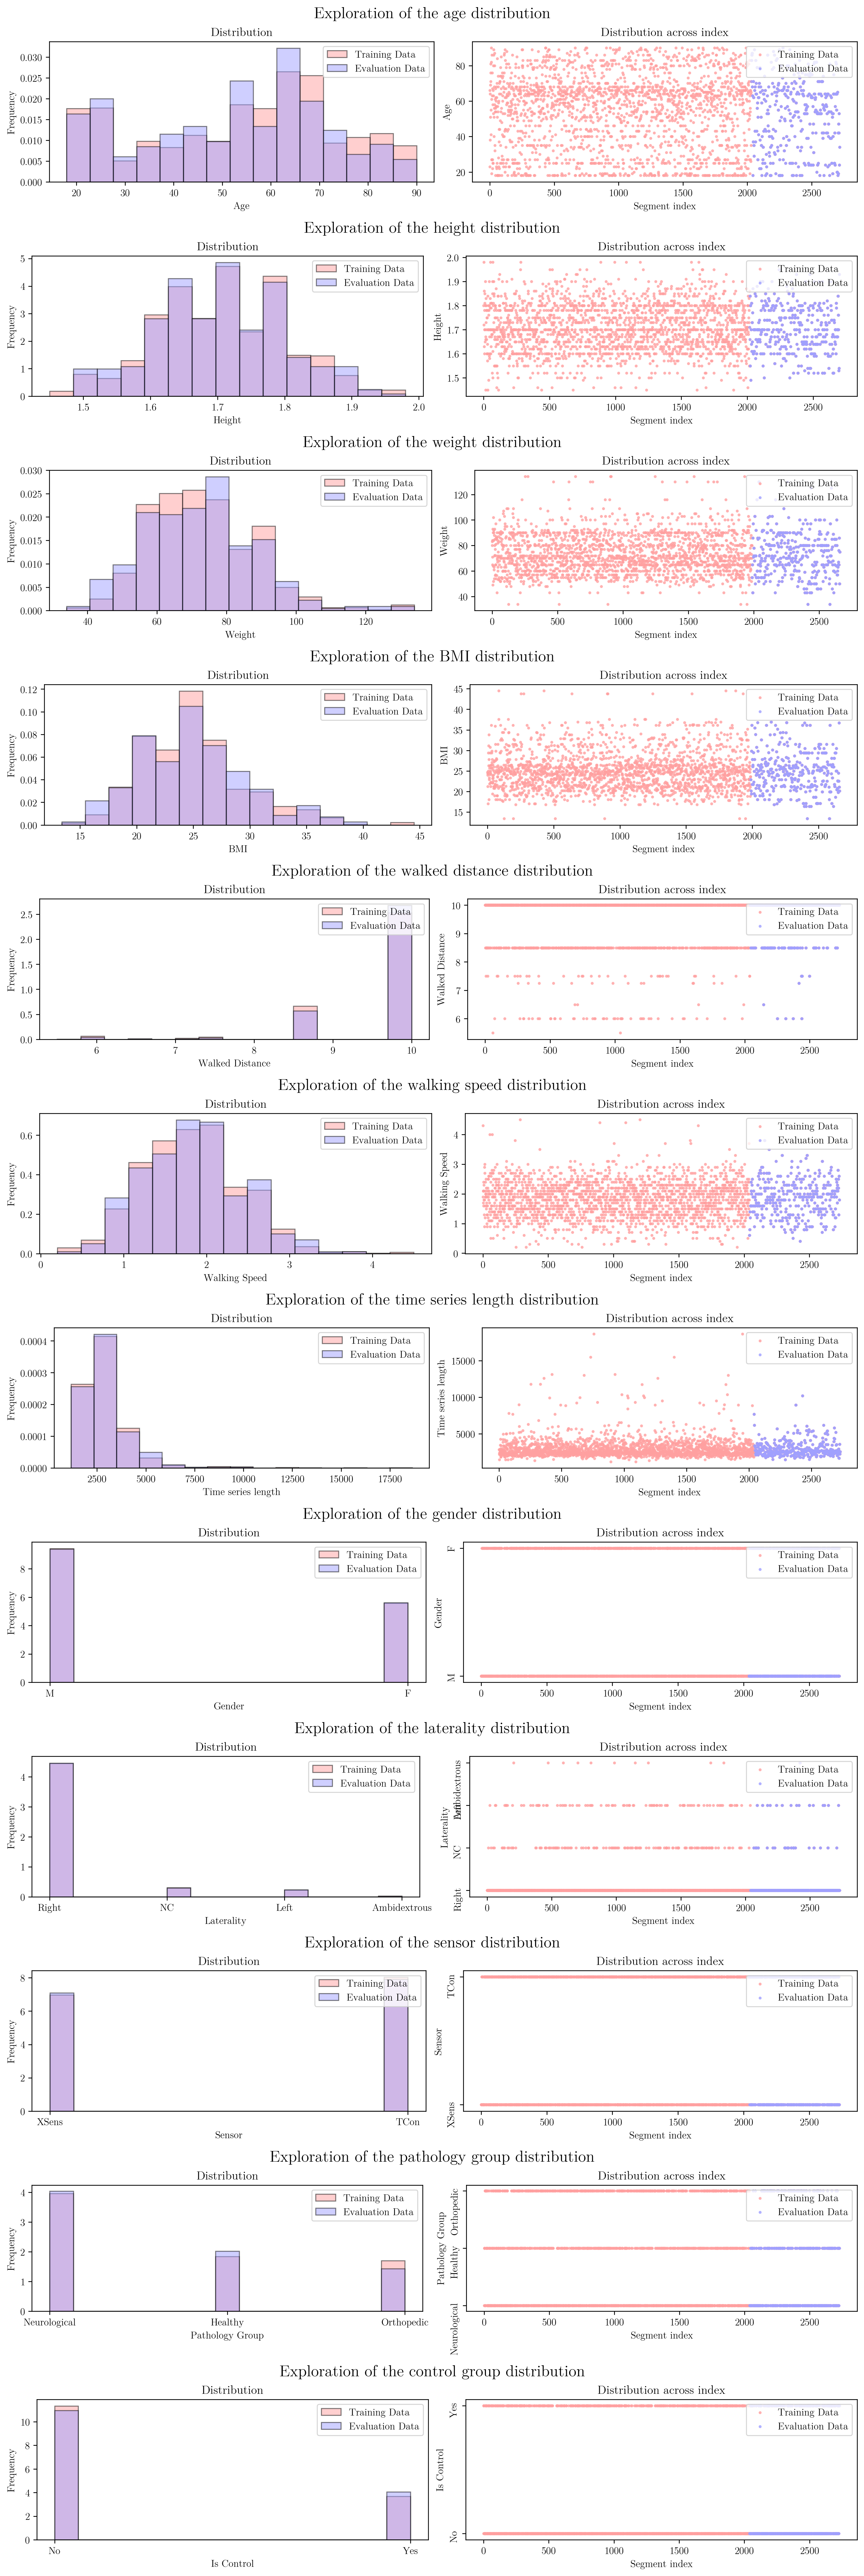

In [22]:
for data_set in data_sets:
    explore_dataset(data_set)
    visualize_data_set(data_set)